# Experiment on a real dataset

In this notebook, we will experiment with SGLD, SGHD algoirthms on a real dataset: [Bank Marketing Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset) and compare the results to NUTS from Pymc3. 

The goal of this dataset is to create a **binary classification** model that predicts whether or not customers will subscribe to a term deposit after a phone calls marketing campaign the bank has performed, based on  17  predictor variables. The dataset consists of 11,000  customers.

The target variable is given as *deposit* and takes on a value of  *yes*  if the customer has subscribed and  *no*  otherwise.

In [1]:
# import libraries 
from sgld import *
from sghd import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pymc3 as pm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### 1. Loading and pre-processing data

In [2]:
# loading data
data = pd.read_csv("bank.csv")
N, d = data.shape
data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [3]:
print("#instances in each class")
print(data['deposit'].value_counts())   # nb of instances in each class
print('------------------\nAny null values?')
print(data.isna().any())

#instances in each class
no     5873
yes    5289
Name: deposit, dtype: int64
------------------
Any null values?
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
deposit      False
dtype: bool


*Transforming categorical features into numerical*

In [4]:
# pre-processing: categorical columns to numerical 
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
encodings = {col:{} for col in cat_cols}
for col in cat_cols:
    uniques = data[col].unique()
    for i, u in enumerate(uniques):
        encodings[col][u] = i

encodings["deposit"] = {'yes':1, 'no':0}

# do deposit alone
data = data.replace(encodings)

In [5]:
data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,0,0,0,2343,0,0,0,5,0,1042,1,-1,0,0,1
1,56,0,0,0,0,45,1,0,0,5,0,1467,1,-1,0,0,1
2,41,1,0,0,0,1270,0,0,0,5,0,1389,1,-1,0,0,1
3,55,2,0,0,0,2476,0,0,0,5,0,579,1,-1,0,0,1
4,54,0,0,1,0,184,1,0,0,5,0,673,2,-1,0,0,1


*Splitting the data into training and test samples*

In [6]:
# separating features and labels
X = data[data.columns[:-1]].values
y = 2*data[data.columns[-1]].values - 1    # make y in {-1, 1}

# splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)
len(X_train), len(X_test)

(8929, 2233)

*Standardising the data*

In [7]:
# centering data and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# scale test data
X_test = scaler.transform(X_test)

### 2. Sanity check: SGD Classifier performance

We will first assess the performance of a simple SGD classifier (from sklearn) on the dataset. 

In [103]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=42)
model.fit(X_train, y_train)
print(f'SGDClassifier: ------------ \nTrain accuracy :{round(model.score(X_train, y_train), 3)}\nTest accuracy :{round(model.score(X_test, y_test),3)}')

SGDClassifier: ------------ 
Train accuracy :0.792
Test accuracy :0.779


### 3. SGLD logistic regression

> The implementation of SGLD is provided in the file `sgld.py`.

**Experimenting with different values of $a, b, \gamma$**

---------------------------------------------------------
We variate the step size from 0.00063 to 7e-05
---------------------------------------------------------


100%|██████████| 4000/4000 [00:02<00:00, 1478.46it/s]


Finished within 2.71 s.


100%|██████████| 4000/4000 [00:02<00:00, 1367.06it/s]


Finished within 2.93 s.


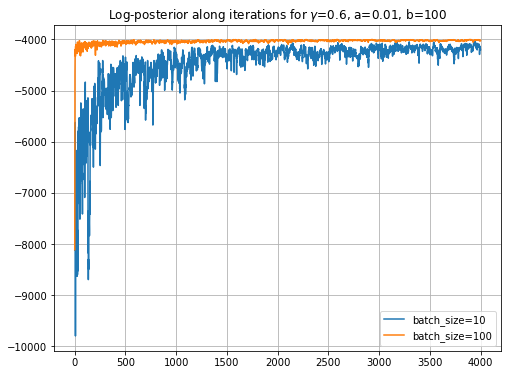

In [19]:
# training an SGLD model 
batches = [10, 100]
a, b =.01, 100    #100
gamma = .6  #.7
sigma=1.
np.random.seed(42)
theta_0 = np.random.rand(X_train.shape[1])
n_iter = 4000

print(f'---------------------------------------------------------')
print(f'We variate the step size from {round(a*(b+0)**(-gamma),5)} to {round(a*(b+n_iter-1)**(-gamma),5)}')
print(f'---------------------------------------------------------')

plt.figure(figsize=(8,6))
for batch_size in batches:
    thetas, step_sizes, log_posts, alphas = sgld_logreg(X_train, y_train, theta_0, sigma, gamma, a, b, batch_size, n_iter, compute_Vs=True)
    plt.plot(log_posts, label=f'batch_size={batch_size}')
    plt.title(f"Log-posterior along iterations for $\\gamma$={gamma}, a={a}, b={b}")
    plt.grid()
    plt.legend()
    
plt.grid()


**Comment:**
For larger batch sizes, the algorithm succeeds in converging faster and log-posterior curve is less chaotic compared to a smaller batch size. However, this also means that the chain converges rapidly to the posterior without having time to explore further areas of the posterior. 

On the other hand, having a curve that fluctuates can result in much variance in the posterior samples. It therefore important to succeed in making a compromise between this 2 extremes.

**In the sequel, we will set the parameters of the model as follows:**
$$ a = 0.01, \;\;\; b=100, \;\;\; \gamma=0.6, \;\;\;\text{batch\_size}=140$$


100%|██████████| 4000/4000 [00:03<00:00, 1324.49it/s]


Finished within 3.02 s.


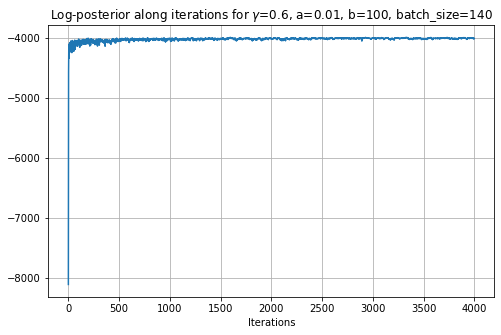

In [362]:
batch_size = 140   
a, b = .01, 100, 
gamma = .6
sigma=1.
np.random.seed(42)
theta_0 = np.random.rand(X_train.shape[1])
n_iter = 4000
thetas, step_sizes, log_posts, alphas = sgld_logreg(X_train, y_train, theta_0, sigma, gamma, a, b, batch_size, n_iter, compute_Vs=True)


plt.figure(figsize=(8,5))
plt.plot(log_posts)
plt.title(f"Log-posterior along iterations for $\\gamma$={gamma}, a={a}, b={b}, batch_size={batch_size}")
plt.grid()
plt.xlabel('Iterations')
plt.show()


**Trace plots**

We consider that we will start sampling from the posterior after iterations $3000$.

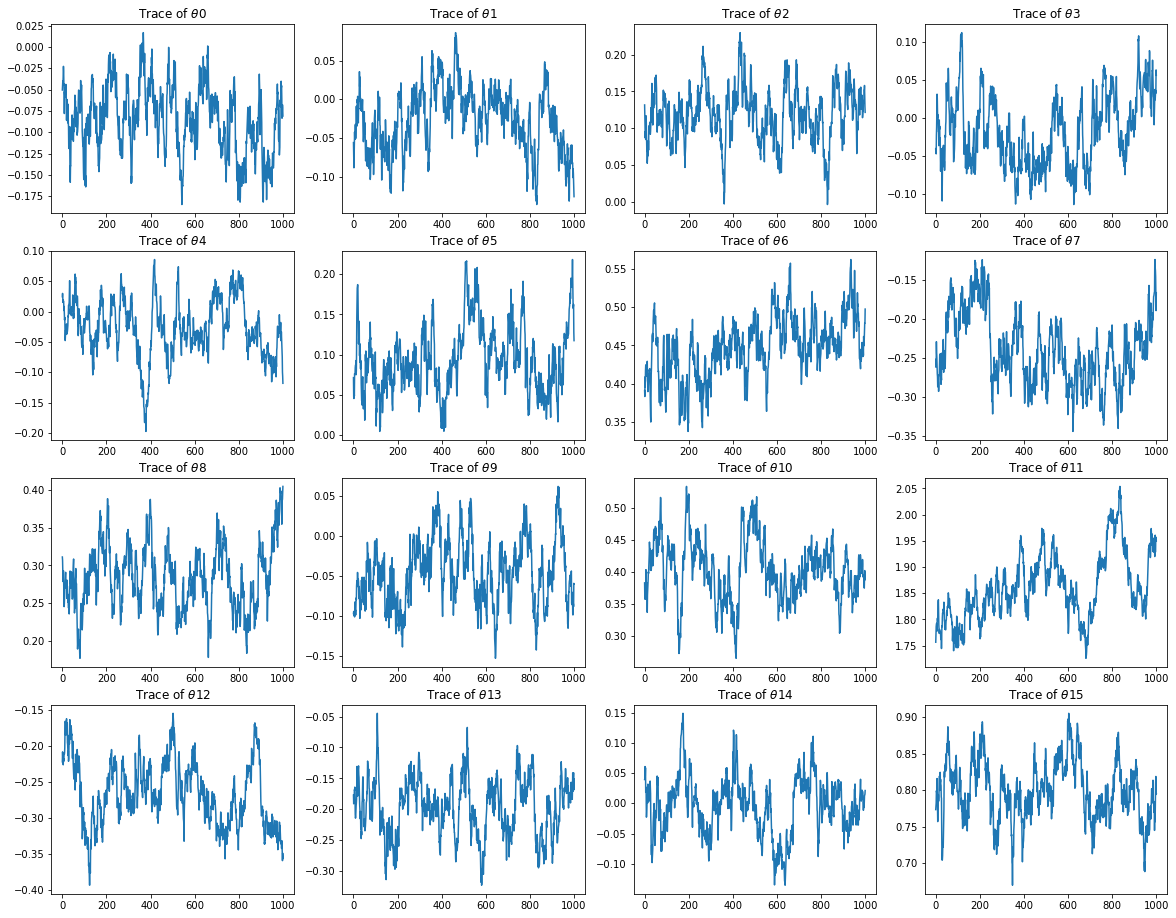

In [363]:
# chain trace 
t_burn_in = 3000  
post_samples = thetas[t_burn_in:]

fig, axes = plt.subplots(4,4, figsize=(20,16))
axes = axes.ravel()
for i in range(16):
    axes[i].plot(post_samples[:, i].reshape(-1,))
    axes[i].title.set_text(f'Trace of $\\theta${i}')

**Auto-correlation of the trace plots**

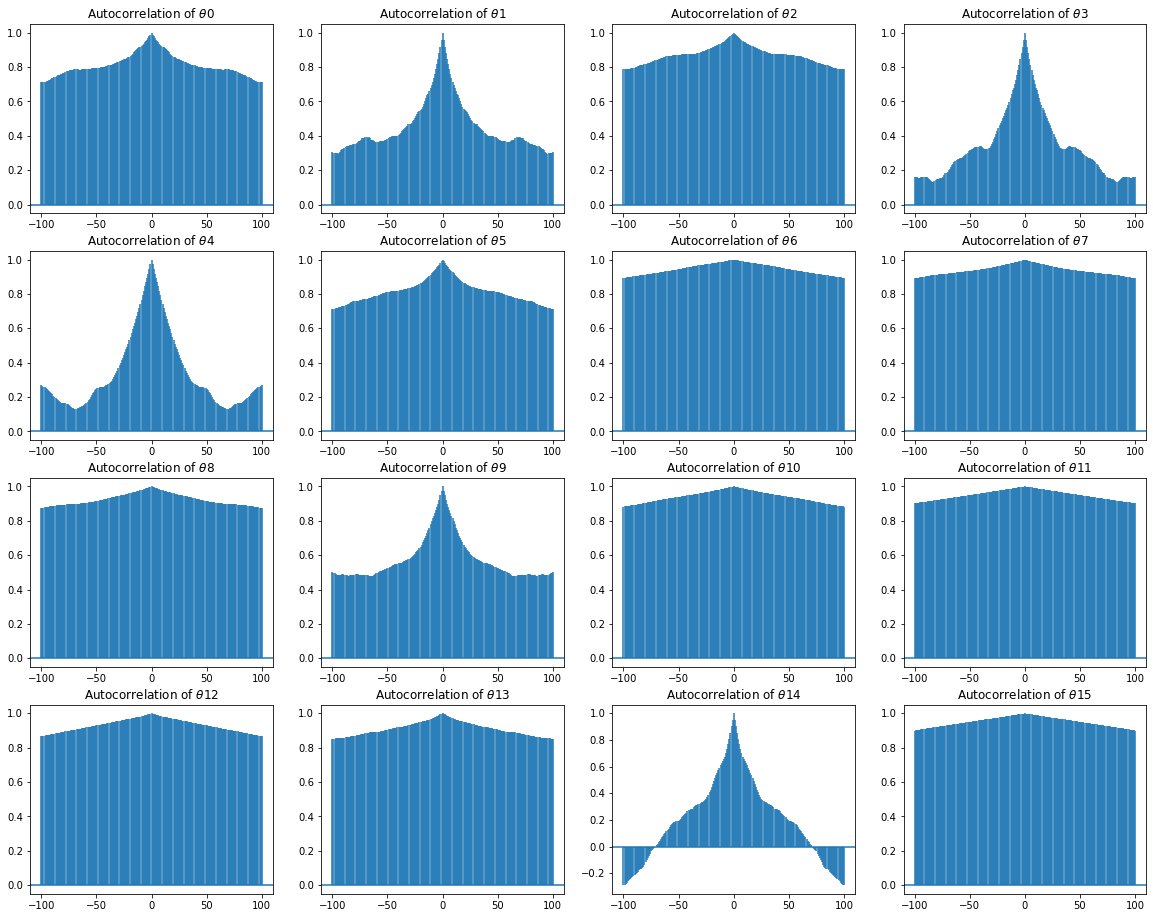

In [356]:
fig, axes = plt.subplots(4,4, figsize=(20,16))
axes = axes.ravel()
for i in range(16):
    axes[i].acorr(post_samples[:, i], maxlags=100)
    axes[i].title.set_text(f'Autocorrelation of $\\theta${i}')

Clearly, the chains does not mix well, which is expected since the step size gets smaller and smaller, thus forcing the algorithm to sample from a small area around one posterior mode.

This will motivate the use of Hamiltonian Monte Carlo with batch updates. 

**Predictions**

We compute the mean and stardard deviation of the model's accuracy over the posterior samples.

In [364]:
t_burn_in = 3000
train_acc = compute_accuracy(X_train, y_train, thetas, t_burn_in=t_burn_in)
print(f'SGLD: --------------------- \nTrain accuracy mean:{round(np.mean(train_acc),3)}\nTrain accuracy std.:{round(np.std(train_acc),3)}')

test_acc = compute_accuracy(X_test, y_test, thetas, t_burn_in=t_burn_in)
print(f'\nTest accuracy mean:{round(np.mean(test_acc),3)}\nTest accuracy std.:{round(np.std(test_acc),3)}')

SGLD: --------------------- 
Train accuracy mean:0.801
Train accuracy std.:0.001

Test accuracy mean:0.788
Test accuracy std.:0.003


### 4. Performance comparison with NUTS from Pymc3

In [371]:
data_train = pd.DataFrame(np.concatenate((X_train, y_train.reshape(-1, 1)),  axis=1), columns=list(data.columns))
data_train["deposit"] = (data_train["deposit"] + 1 )//2

# complete model of all the features 
complete_model = 'deposit ~ 0 + ' + ' + '.join(list(data.columns[:-1]))   # 0 is for removing the intercept
complete_model

'deposit ~ 0 + age + job + marital + education + default + balance + housing + loan + contact + day + month + duration + campaign + pdays + previous + poutcome'

In [372]:
import pymc3 as pm

# defining the model
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        complete_model, data_train, family=pm.glm.families.Binomial()
    )
    trace = pm.sample(1000, tune=1000, init="adapt_diag")

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/var/folders/_4/__fjqfv90fvf8833bp2ysjzw0000gn/T/ipykernel_8575/162714046.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000, init="adapt_diag")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [poutcome, previous, pdays, campaign, duration, month, day, contact, loan, housing, balance, default, education, marital, job, age]


/Users/amalchaoui/opt/anaconda3/envs/mml/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amalchaoui/opt/anaconda3/envs/mml/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amalchaoui/opt/anaconda3/envs/mml/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amalchaoui/opt/anaconda3/envs/mml/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


/Users/amalchaoui/opt/anaconda3/envs/mml/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


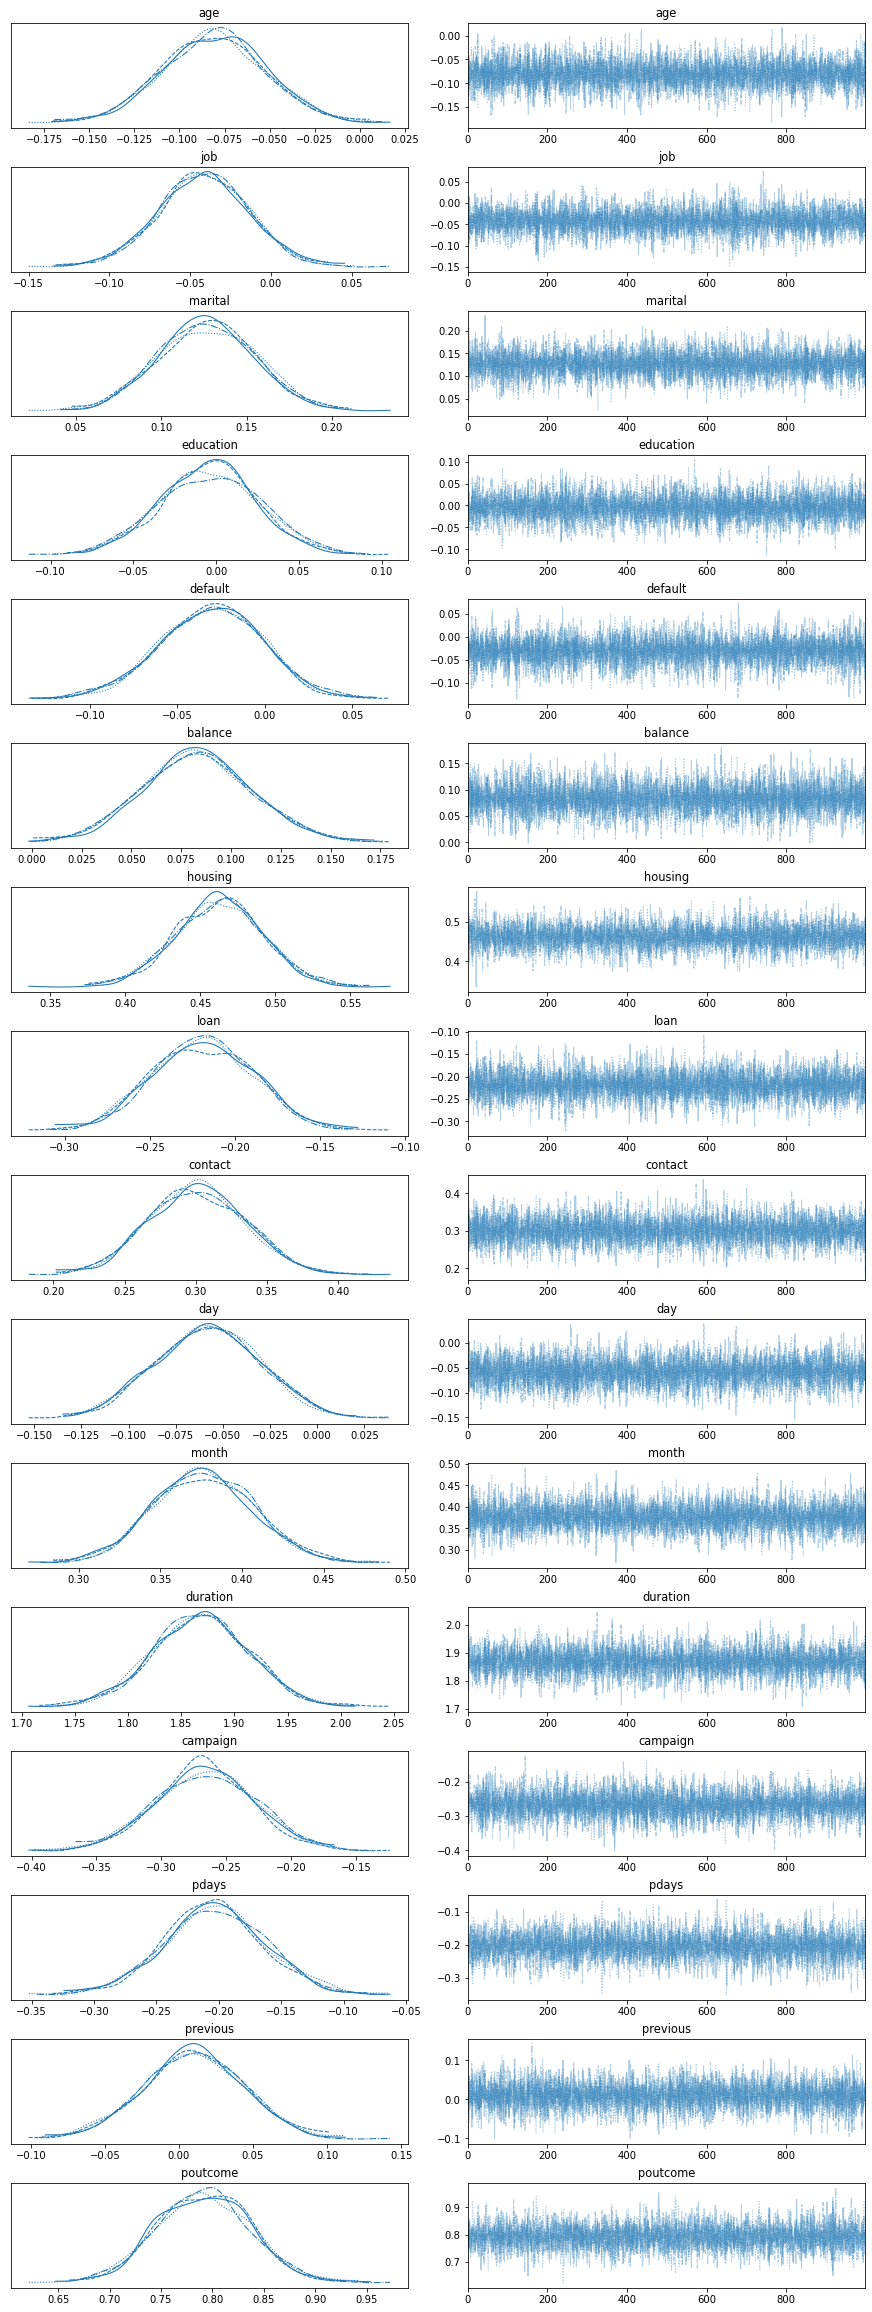

In [381]:
# plot of the trace
pm.plot_trace(trace)
plt.show()


In [382]:
# posterior samples 
post_samples = np.concatenate(tuple(trace[col].reshape(-1,1) for col in list(data.columns[:-1])), axis=1)

**Predictions**

We compute the mean and stardard deviation of the model's accuracy over the posterior samples.

In [374]:
train_nuts_acc = compute_accuracy(X_train, y_train, post_samples)
print(f'Pymc NUTS: -------------- \nTrain accuracy mean:{round(np.mean(train_nuts_acc),3)}\nTest accuracy std.:{round(np.std(train_nuts_acc),3)}')
test_nuts_acc = compute_accuracy(X_test, y_test, post_samples)
print(f'\nTest accuracy mean:{round(np.mean(test_nuts_acc),3)}\nTest accuracy std.:{round(np.std(test_nuts_acc),3)}')

Pymc NUTS: -------------- 
Train accuracy mean:0.801
Test accuracy std.:0.001

Test accuracy mean:0.79
Test accuracy std.:0.002


### 5. SGHD logistic regression

> The notebook `sghd.ipynb` explains the motivation behind Stochastic Gradient Hamiltonian Dynamic (SGHD). It also compares its performance to that of SGHD on  2 toy datasets: linearly  separable classes  and non-linearly separable classes (circular shape classes).

> The implementation of SGHD is provided in the file `sghd.py`.

**Computing the mass matrix M_H**
We recall that the Hamiltonian $H(q,p) = -\log \pi(q) + p^TM_Hp$ introduces that mass matrix $M_H$ that encodes relevant information about the posterior shape. 

In our case, we will compute $M_H$ from the covariance of the posterior samples obtained by SGLD. 

In [383]:
mean_post_samples = np.mean(post_samples, axis=0)
M_mass = 1/(len(post_samples)-1) * (post_samples - mean_post_samples).T.dot(post_samples - mean_post_samples)

In [384]:
N, d = X_train.shape
batch_size = 140    
n_iter = 4000  # nb of iterations
sigma = 1 
h_step = .5    # size of the leapfrog step
n_steps = 80    # nb of one Hamiltonian dynamic steps

# initialising theta
theta_0 = np.ones(d)

# posterior samples from SGHD 
samples, log_posts, accept_ratio, accept_probas = sghd_logreg(X_train, y_train, theta_0, h_step, n_steps, M_mass, sigma=sigma, batch_size=batch_size, n_iter=n_iter)
print(f'Acceptance ratio : {accept_ratio}')

  0%|          | 0/4000 [00:00<?, ?it/s]/Users/amalchaoui/Documents/G4/S1/BML/paper_work/sgld.py:33: RuntimeWarning: divide by zero encountered in log
  log_lkl = np.sum(np.log(expit(y * np.dot(X, theta))), axis=0) # log-likelihood
  0%|          | 18/4000 [00:00<00:22, 178.44it/s]/Users/amalchaoui/Documents/G4/S1/BML/paper_work/sghd.py:196: RuntimeWarning: invalid value encountered in double_scalars
  log_proba_accept = min(0, Hamlt_old - Hamlt_new)
100%|██████████| 4000/4000 [00:20<00:00, 193.56it/s]

Finished within 20.67 s.
Acceptance ratio : 0.19725


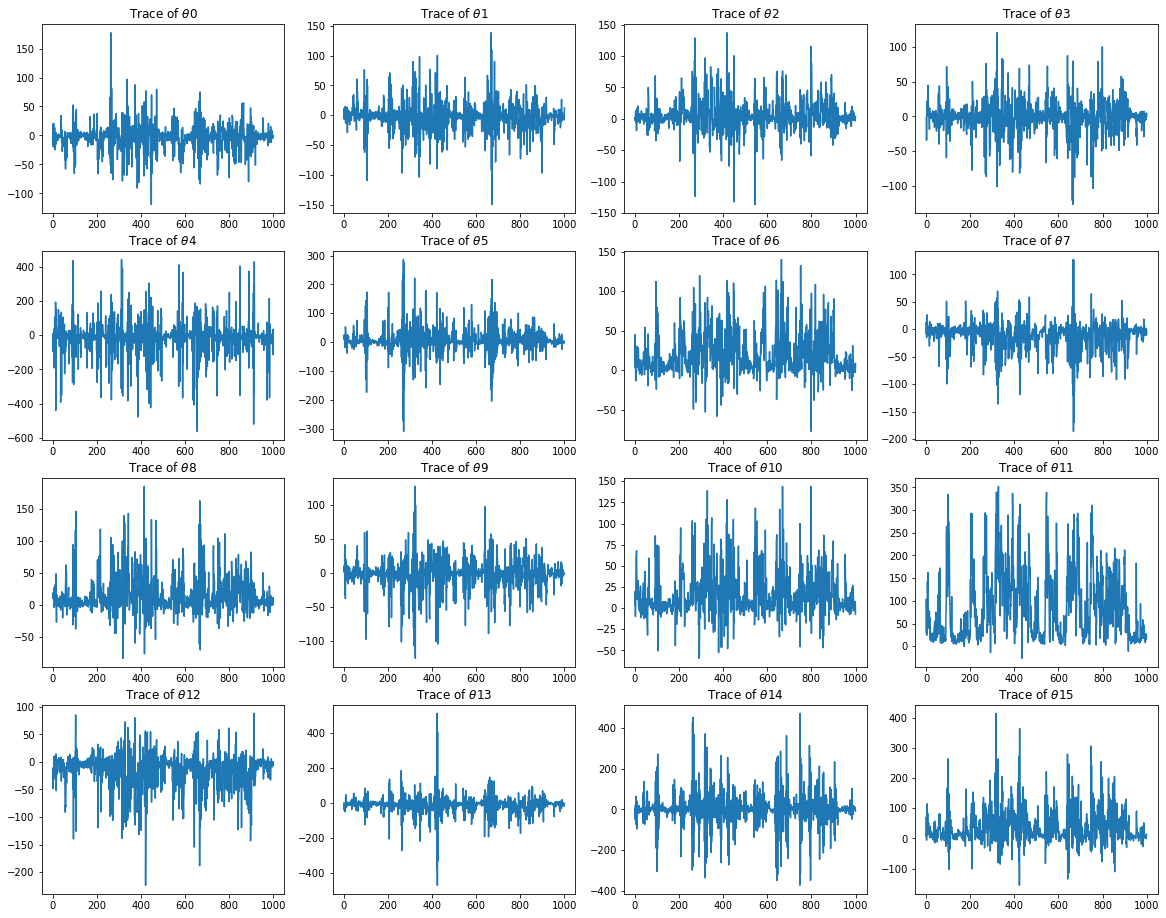

In [385]:
# chain trace 
t_burn_in = 3000  
post_samples = samples[t_burn_in:]

fig, axes = plt.subplots(4,4, figsize=(20,16))
axes = axes.ravel()
for i in range(16):
    axes[i].plot(post_samples[:, i].reshape(-1,))
    axes[i].title.set_text(f'Trace of $\\theta${i}')

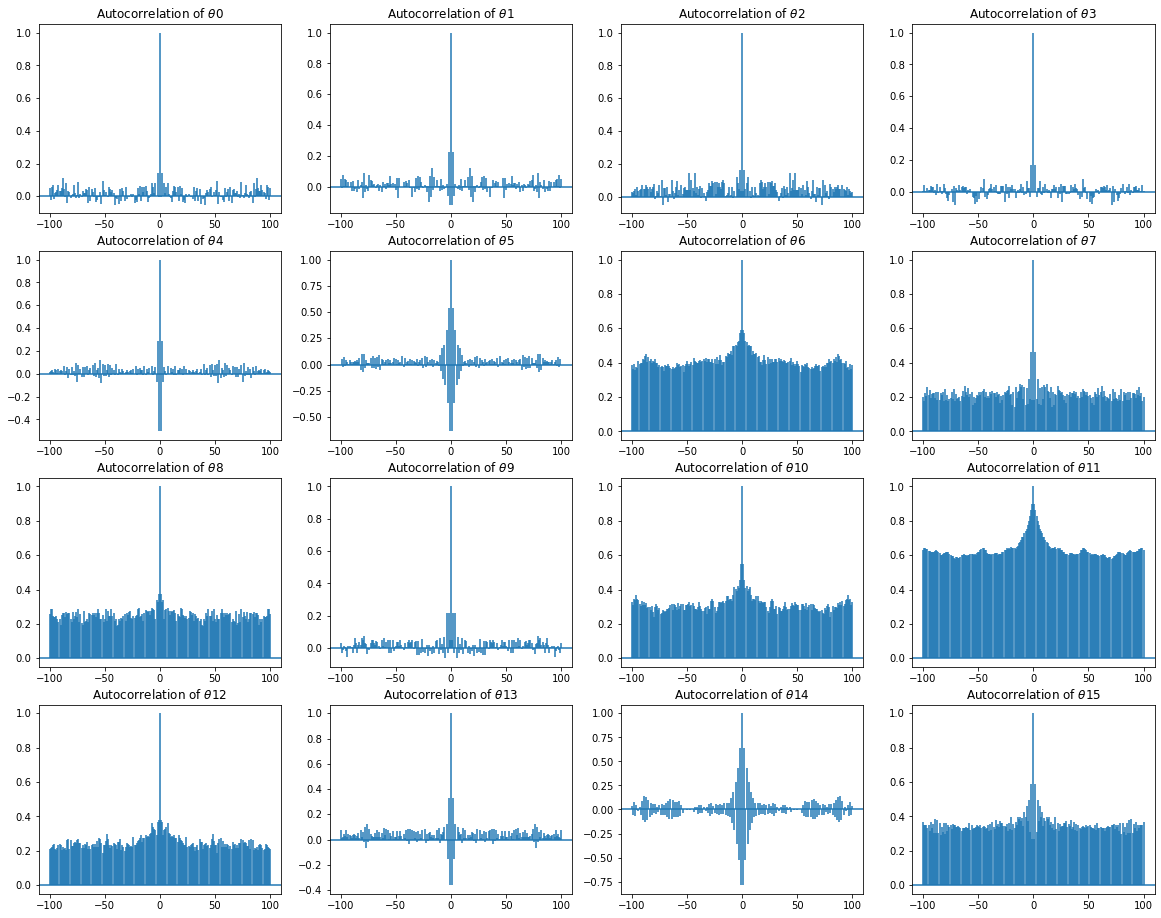

In [386]:
fig, axes = plt.subplots(4,4, figsize=(20,16))
axes = axes.ravel()
for i in range(16):
    axes[i].acorr(samples[t_burn_in:, i], maxlags=100)
    axes[i].title.set_text(f'Autocorrelation of $\\theta${i}')

**Predictions**

In [387]:
t_burn_in =3000
theta_map = samples[t_burn_in+1:]
train_acc = compute_accuracy(X_train, y_train, samples, t_burn_in=t_burn_in)
print(f'SGHD: --------------------- \nTrain accuracy mean:{round(np.mean(train_acc),3)}\nTrain accuracy std.:{round(np.std(train_acc),3)}')

test_acc = compute_accuracy(X_test, y_test, samples, t_burn_in=t_burn_in)
print(f'SGHD: --------------------- \nTest accuracy mean:{round(np.mean(test_acc),3)}\nTest accuracy std.:{round(np.std(test_acc),3)}')


SGHD: --------------------- 
Train accuracy mean:0.713
Train accuracy std.:0.042
SGHD: --------------------- 
Test accuracy mean:0.708
Test accuracy std.:0.04


**Comment:**

We succeeded to decorrelate the movements of the chain (small autocorrelation values compared to SGLD), yet at the price of a loss in performance. 

It is also important to mention that although SGHD computes the necessary updates on a small batch at each iteration, the computation time required for executing SGHD is much higher ($\approx60$ s) compared to SGLD ($\approx2-3$ s), since SGHD (or HMC) requires evaluating the acceptance probability at each intreation with is computed over the whole dataset. 

Finally, successfully traning SGHD depends heavily on the mass matrix $M_H$, which might not be easily accessible in practice. 